In [14]:
import os
import torch
from torch.utils.data import DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib import rc
import seaborn as sns
from util import plot_samples
import re
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rcParams.update({
    'font.size': 20,          # Global font size
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 20,     # X and Y axis labels font size
    'xtick.labelsize': 15,    # X-axis tick labels font size
    'ytick.labelsize': 15,    # Y-axis tick labels font size
    'legend.fontsize': 20,    # Legend font size
})
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

result_dir_vanilla = 'results_PC/20240806_084842_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.0_PAT20_MOD/'
circuit_vanilla = torch.load(result_dir_vanilla + 'circuit.pt', map_location=torch.device('cpu')).to(device)
pf_vanilla = torch.load(result_dir_vanilla + 'pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_vanilla.eval()
pf_vanilla.eval()
model_vanilla = (circuit_vanilla, pf_vanilla)
with open(result_dir_vanilla + 'evaluate_results.json', 'r') as file:
    eval_dic_vanilla = json.load(file)

result_dir_aug = 'results_PC/20240807_190852_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM-1.0_PAT5_AUG_MOD/'
circuit_aug = torch.load(result_dir_aug + 'circuit.pt', map_location=torch.device('cpu')).to(device)
pf_aug = torch.load(result_dir_aug + 'pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_aug.eval()
pf_aug.eval()
model_aug = (circuit_aug, pf_aug)
with open(result_dir_aug + 'evaluate_results.json', 'r') as file:
    eval_dic_aug = json.load(file)

result_dir_reg = 'results_PC/20240806_090646_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM0.1_PAT20_MOD/'
circuit_reg = torch.load(result_dir_reg + 'circuit.pt', map_location=torch.device('cpu')).to(device)
pf_reg = torch.load(result_dir_reg + 'pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_reg.eval()
pf_reg.eval()
model_reg = (circuit_reg, pf_reg)
with open(result_dir_reg + 'evaluate_results.json', 'r') as file:
    eval_dic_reg = json.load(file)

result_dir_reg_plus = 'results_PC/20240806_102138_S42_E30_BS64_LR1e-01_H28_NSM8_NIM8_ID784_mnist_LAM1.0_PAT20_MOD/'
circuit_reg_plus = torch.load(result_dir_reg_plus + 'circuit.pt', map_location=torch.device('cpu')).to(device)
pf_reg_plus = torch.load(result_dir_reg_plus + 'pf_circuit.pt', map_location=torch.device('cpu')).to(device)
circuit_reg_plus.eval()
pf_reg_plus.eval()
model_reg_plus = (circuit_reg_plus, pf_reg_plus)
with open(result_dir_reg_plus + 'evaluate_results.json', 'r') as file:
    eval_dic_reg_plus = json.load(file)

# Plots

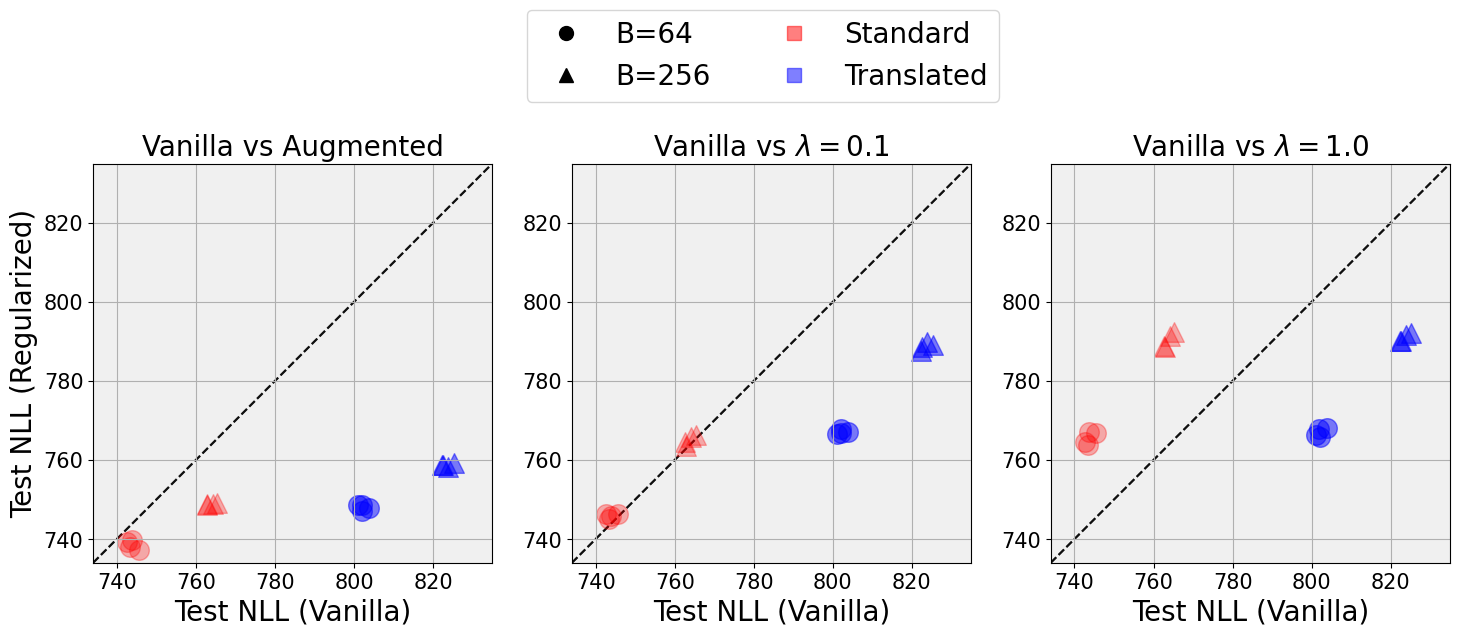

In [19]:
# Define the result directory
result_dir = 'results_PC'

# Regular expression pattern to match the directory names and extract hyperparameters
pattern = re.compile(
    r"(?P<datetime>2024(0[8-9]|1[0-2])\d{2}_\d{6}|202[5-9]\d{4}_\d{6})_"
    r"S(?P<seed>\d+)_"
    r"E(?P<num_epochs>\d+)_"
    r"BS(?P<batch_size>\d+)_"
    r"LR(?P<lr>[\de.-]+)_"
    r"H(?P<height>\d+)_"
    r"NSM(?P<num_sum_units>\d+)_"
    r"NIM(?P<num_input_units>\d+)_"
    r"ID(?P<input_dim>\d+)_"
    r"(?P<data>[^_]+)_"
    r"LAM(?P<lam>-?[\de.-]+)_"
    r"PAT(?P<patience>\d+)"
    r"(?:_AUG)?(?:_MOD)?"
)


directories = os.listdir(result_dir)
data_dict = defaultdict(lambda: defaultdict(dict))

# Extract nll_val from directories and organize by batch_size and lam
for directory in directories:
    match = pattern.match(directory)
    if match:
        params = match.groupdict()
        batch_size = int(params['batch_size'])
        lam = float(params['lam'])
        if batch_size in [64, 256] and lam in [-1.0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            results_path = os.path.join(result_dir, directory, 'results.json')
            if os.path.exists(results_path):
                with open(results_path, 'r') as f:
                    results = json.load(f)
                    test_nll = results.get('test_val')
                    aug_test_nll = results.get('aug_test_val')
                    nll_val = results.get('nll_val')
                    if test_nll is not None and aug_test_nll is not None:
                        seed = int(params['seed'])
                        data_dict[batch_size][lam][seed] = (test_nll, aug_test_nll, nll_val)

# Define colors for standard and augmented results
color_standard = 'red'
color_augmented = 'blue'

# Create scatter plots in a 1x2 grid
fig1, axs1 = plt.subplots(1, 3, figsize=(15, 7))

batch_sizes = [64, 256]
lams = [-1.0, 0.1, 1.0]
markers = ['o', '^']  # Different markers for different batch sizes ('o' for 64, '^' for 256)

# Determine global limits for all subplots
all_nll = []
for batch_size in batch_sizes:
    for lam in lams:
        for seed in data_dict[batch_size][lam].keys():
            test_nll, aug_test_nll, _ = data_dict[batch_size][lam][seed]
            all_nll.append(test_nll)
            all_nll.append(aug_test_nll)
global_min = 734  # You can uncomment the next line if you want to determine min dynamically
# global_min = min(all_nll)
global_max = 835  # You can uncomment the next line if you want to determine max dynamically
# global_max = max(all_nll)

for i, batch_size in enumerate(batch_sizes):
    for j, lam in enumerate(lams):
        ax = axs1[j]
        seeds = set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys())
        for seed in seeds:
            test_nll_0, aug_test_nll_0, _ = data_dict[batch_size][0][seed]
            test_nll_lam, aug_test_nll_lam, _ = data_dict[batch_size][lam][seed]
            ax.scatter(test_nll_0, test_nll_lam, color=color_standard, marker=markers[i], s=200, label=f'Seed {seed} (B={batch_size})', alpha = 0.3)
            ax.scatter(aug_test_nll_0, aug_test_nll_lam, color=color_augmented, marker=markers[i], s=200, alpha = 0.5)
        if lam == -1:
            ax.set_title(f'Vanilla vs Augmented')
        else:
            ax.set_title(f'Vanilla vs $\\lambda = {lam}$')
        ax.set_facecolor('#f0f0f0')
        ax.set_xlabel('Test NLL (Vanilla)')
        ax.set_ylabel(f'Test NLL (Regularized)')
        if j == 0:
            ax.set_ylabel('Test NLL (Regularized)')
        else:
            ax.set_ylabel('')
        lims = [global_min, global_max]
        ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.grid(True)

handles = [
    plt.Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=10, label='B=64'),
    plt.Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=10, label='B=256'),
    plt.Line2D([0], [0], marker='s', color=color_standard, linestyle='None', markersize=10, label='Standard', alpha = 0.5),
    plt.Line2D([0], [0], marker='s', color=color_augmented, linestyle='None', markersize=10, label='Translated', alpha = 0.5)
]
fig1.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.522, 1.0))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/pc/test_scatter_pc_mnist.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [24]:
def compute_bpd(nll, dimensionality=784):
    return nll / (np.log(2) * dimensionality)

relative_errors = []
std_test_nll_means = []
aug_test_nll_means = []
batch_size = 64
for lam in [-1.0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    all_test_nll = []
    all_aug_test_nll = []
    for seed in data_dict[batch_size][lam].keys():
        test_nll, aug_test_nll, _ = data_dict[batch_size][lam][seed]
        all_test_nll.append(test_nll)
        all_aug_test_nll.append(aug_test_nll)
    test_nll_mean = np.mean(all_test_nll)
    std_test_nll_means.append(test_nll_mean)
    test_nll_std = np.std(all_test_nll)
    aug_test_nll_mean = np.mean(all_aug_test_nll)
    aug_test_nll_means.append(aug_test_nll_mean)
    aug_test_nll_std = np.std(all_aug_test_nll)
    
    # Compute BPD
    test_bpd_mean = compute_bpd(test_nll_mean)
    test_bpd_std = compute_bpd(test_nll_std)
    aug_test_bpd_mean = compute_bpd(aug_test_nll_mean)
    aug_test_bpd_std = compute_bpd(aug_test_nll_std)
    
    # Compute relative error
    relative_error = ((aug_test_nll_mean - test_nll_mean) / test_nll_mean) * 100
    relative_errors.append(relative_error)
    
    print(f"Lambda = {lam} (Batch Size = {batch_size})")
    print(f"Standard Test NLL: Mean = {test_nll_mean:.2f}, Std = {test_nll_std:.2f}")
    print(f"Standard Test BPD: Mean = {test_bpd_mean:.4f}, Std = {test_bpd_std:.4f}")
    print(f"Translated Test NLL: Mean = {aug_test_nll_mean:.2f}, Std = {aug_test_nll_std:.2f}")
    print(f"Translated Test BPD: Mean = {aug_test_bpd_mean:.4f}, Std = {aug_test_bpd_std:.4f}")
    print(f"Relative Error: {relative_error:.2f}%\n")


Lambda = -1.0 (Batch Size = 64)
Standard Test NLL: Mean = 738.59, Std = 1.04
Standard Test BPD: Mean = 1.3591, Std = 0.0019
Translated Test NLL: Mean = 748.06, Std = 0.58
Translated Test BPD: Mean = 1.3766, Std = 0.0011
Relative Error: 1.28%

Lambda = 0 (Batch Size = 64)
Standard Test NLL: Mean = 743.81, Std = 1.09
Standard Test BPD: Mean = 1.3687, Std = 0.0020
Translated Test NLL: Mean = 802.21, Std = 0.99
Translated Test BPD: Mean = 1.4762, Std = 0.0018
Relative Error: 7.85%

Lambda = 0.1 (Batch Size = 64)
Standard Test NLL: Mean = 745.82, Std = 0.52
Standard Test BPD: Mean = 1.3724, Std = 0.0010
Translated Test NLL: Mean = 767.04, Std = 0.53
Translated Test BPD: Mean = 1.4115, Std = 0.0010
Relative Error: 2.84%

Lambda = 0.2 (Batch Size = 64)
Standard Test NLL: Mean = 750.12, Std = 0.00
Standard Test BPD: Mean = 1.3803, Std = 0.0000
Translated Test NLL: Mean = 761.92, Std = 0.00
Translated Test BPD: Mean = 1.4021, Std = 0.0000
Relative Error: 1.57%

Lambda = 0.3 (Batch Size = 64)
St

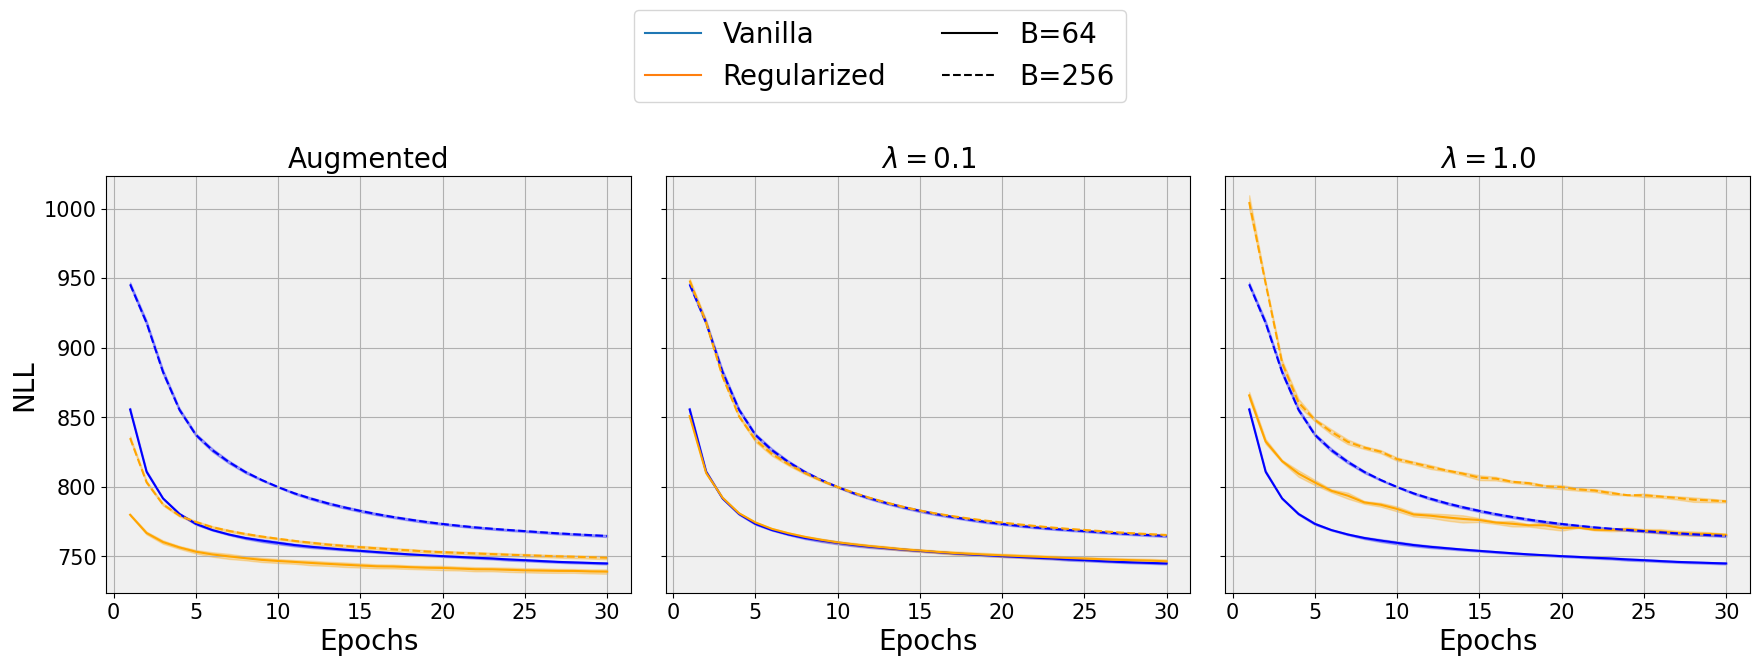

In [23]:
# Function to truncate or pad lists to a fixed length
def truncate_or_pad(data, length=30):
    if len(data) >= length:
        return data[:length]
    else:
        return data + [data[-1]] * (length - len(data))

# Function to calculate mean and std for truncated or padded lists
def calculate_mean_std(truncated_data):
    truncated_array = np.array(truncated_data)
    mean = np.mean(truncated_array, axis=0)
    std = np.std(truncated_array, axis=0)
    return mean, std

# Function to plot validation loss curves with confidence intervals
def plot_validation_loss(data_dict):
    batch_sizes = [64, 256]
    lams = [-1.0, 0.1, 1.0]
    epochs = 30  # Fixed number of epochs
    
    fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    
    for j, lam in enumerate(lams):
        ax = axs2[j]
        for i, batch_size in enumerate(batch_sizes):
            seeds = sorted(set(data_dict[batch_size][0].keys()) & set(data_dict[batch_size][lam].keys()))
            if seeds:
                truncated_nll_vals_0 = [truncate_or_pad(data_dict[batch_size][0][seed][2], epochs) for seed in seeds]
                truncated_nll_vals_lam = [truncate_or_pad(data_dict[batch_size][lam][seed][2], epochs) for seed in seeds]
                
                mean_nll_0, std_nll_0 = calculate_mean_std(truncated_nll_vals_0)
                mean_nll_lam, std_nll_lam = calculate_mean_std(truncated_nll_vals_lam)
                
                epoch_range = np.arange(1, epochs + 1)
                
                # Plot mean and confidence interval for vanilla (lambda = 0)
                ax.plot(epoch_range, mean_nll_0, color='blue', linestyle='-' if batch_size == 64 else '--', label=f'Vanilla (B={batch_size})' if lam == lams[0] else "")
                ax.fill_between(epoch_range, mean_nll_0 - std_nll_0, mean_nll_0 + std_nll_0, color='blue', alpha=0.3)
                
                # Plot mean and confidence interval for regularized (lambda > 0)
                ax.plot(epoch_range, mean_nll_lam, color='orange', linestyle='-' if batch_size == 64 else '--', label=f'Regularized (B={batch_size})' if lam == lams[0] else "")
                ax.fill_between(epoch_range, mean_nll_lam - std_nll_lam, mean_nll_lam + std_nll_lam, color='orange', alpha=0.3)
        if lam == -1:
            ax.set_title('Augmented')
        else:
            ax.set_title(f'$\\lambda = {lam}$')
        ax.set_facecolor('#f0f0f0')
        ax.set_xlabel('Epochs')
        if j == 0:
            ax.set_ylabel('NLL')
        ax.grid(True)
    
    handles = [
        plt.Line2D([0], [0], color=colors[0], label='Vanilla'),
        plt.Line2D([0], [0], color=colors[1], label='Regularized'),
        plt.Line2D([0], [0], linestyle='-', color='#000000', label='B=64'),
        plt.Line2D([0], [0], linestyle='--', color='#000000', label='B=256')
    ]
    fig2.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.15))
    plt.savefig('images/pc/val_loss_curve_pc_mnist.pdf', format='pdf', bbox_inches='tight')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
colors = ['#1f77b4', '#ff7f0e']
# Load and plot data for PC
valid_batch_sizes = [64, 256]
valid_lams = [0, 0.1, 1.0]
plot_validation_loss(data_dict)

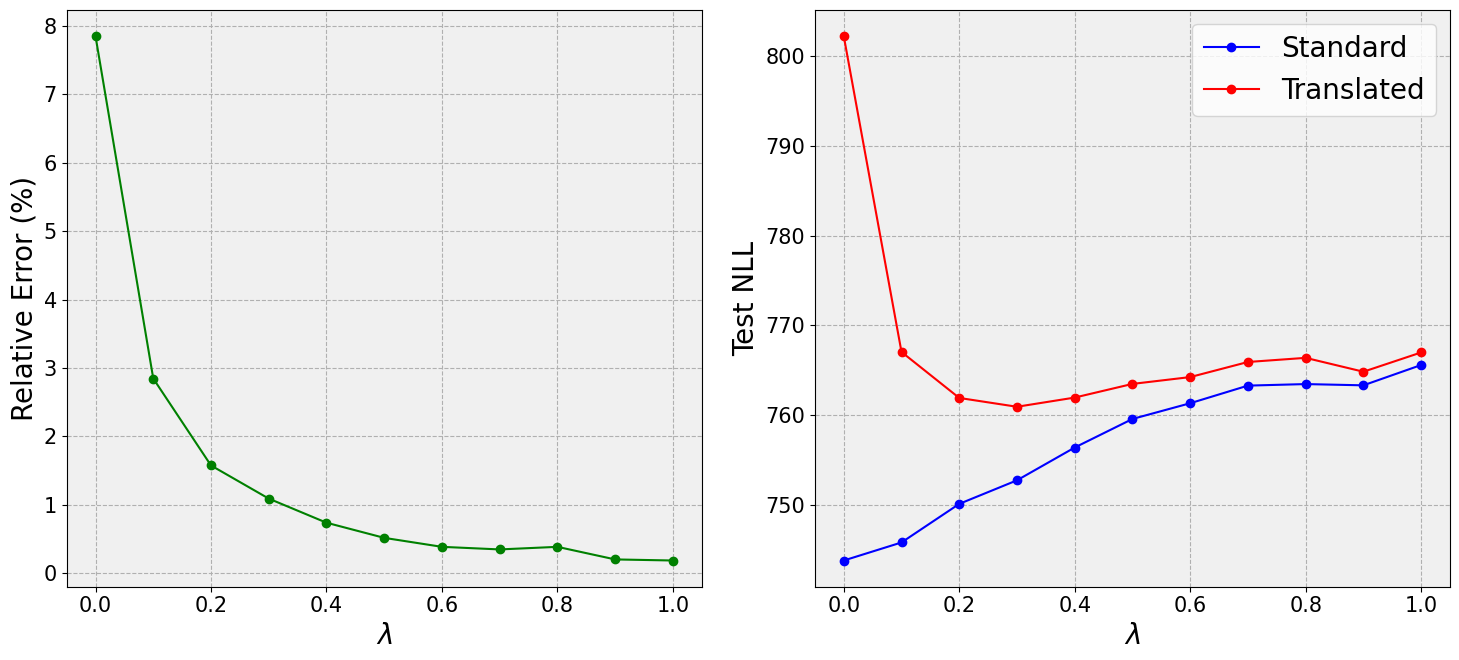

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
lams = np.array([-1.0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# First subplot: Relative Error vs. λ
axes[0].plot(lams[1:], relative_errors[1:], marker='o', linestyle='-', color='g', label='Data Points')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Relative Error (%)')
#axes[0].set_title('Relative Error vs. $\lambda$')
axes[0].set_facecolor('#f0f0f0')
axes[0].grid(True, which="both", ls="--")

# Second subplot: Test NLL vs. λ
axes[1].plot(lams[1:], std_test_nll_means[1:], marker='o', linestyle='-', color='b', label='Standard')
axes[1].plot(lams[1:], aug_test_nll_means[1:], marker='o', linestyle='-', color='r', label='Translated')
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('Test NLL')
#axes[1].set_title('Test NLL vs. $\lambda$')
axes[1].legend(loc='upper right')
axes[1].set_facecolor('#f0f0f0')
axes[1].grid(True, which="both", ls="--")

# Adjust layout and show plot
plt.savefig('images/pc/relerrors_mnist_pc.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()#rect=[0, 0, 1, 0.95]
plt.show()


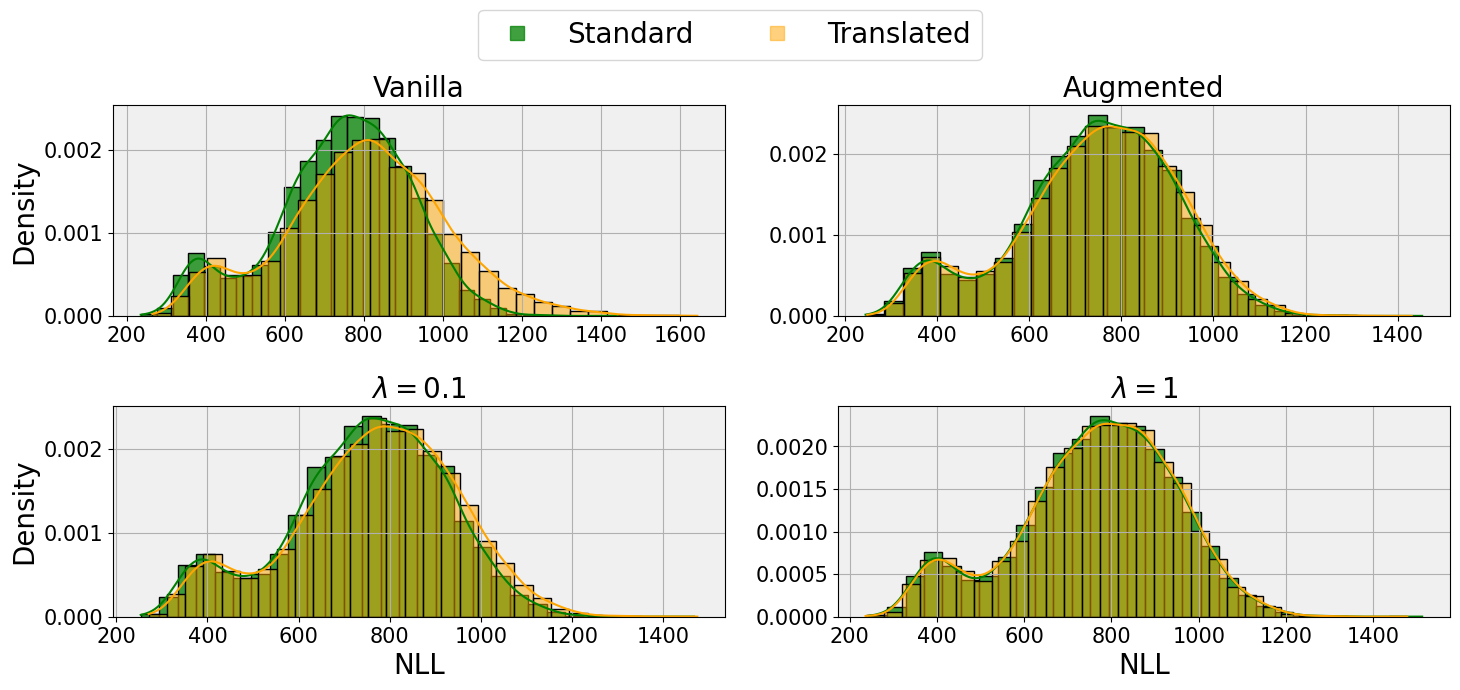

In [25]:
test_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']['mnist']
train_lls_vanilla = eval_dic_vanilla['train_nll_mnist']
test_lls_vanilla_aug = eval_dic_vanilla['aug_nll_mnist']
test_lls_aug = eval_dic_aug['OOD_NLLs_test']['mnist']
train_lls_aug = eval_dic_aug['train_nll_mnist']
test_lls_aug_aug = eval_dic_aug['aug_nll_mnist']
test_lls_regularized = eval_dic_reg['OOD_NLLs_test']['mnist']
train_lls_regularized = eval_dic_reg['train_nll_mnist']
test_lls_regularized_aug = eval_dic_reg['aug_nll_mnist']
test_lls_regularized_plus = eval_dic_reg_plus['OOD_NLLs_test']['mnist']
train_lls_regularized_plus = eval_dic_reg_plus['train_nll_mnist']
test_lls_regularized_plus_aug = eval_dic_reg_plus['aug_nll_mnist']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][0])
sns.histplot(np.array(test_lls_vanilla_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][0])
axs[0][0].set_title('Vanilla')
axs[0][0].set_ylabel('Density')  # Keep y-axis label for the first subplot
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].grid(True)

sns.histplot(np.array(test_lls_aug), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][1])
sns.histplot(np.array(test_lls_aug_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][1])
axs[0][1].set_title('Augmented')
axs[0][1].set_ylabel('')  # Keep y-axis label for the first subplot
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].grid(True)

sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][0])
sns.histplot(np.array(test_lls_regularized_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][0])
axs[1][0].set_title('$\lambda = 0.1$')
axs[1][0].set_xlabel('NLL')
axs[1][0].set_ylabel('Density')  # Remove y-axis label for the second subplot
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].grid(True)

sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][1])
sns.histplot(np.array(test_lls_regularized_plus_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][1])
axs[1][1].set_title('$\lambda = 1$')
axs[1][1].set_xlabel('NLL')
axs[1][1].set_ylabel('')  # Remove y-axis label for the third subplot
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].grid(True)

handles = [
    plt.Line2D([0], [0], linestyle='None', marker='s', color='green', markersize=10, alpha=0.75, label='Standard'),
    plt.Line2D([0], [0], linestyle='None', marker='s', color='orange', markersize=10, alpha=0.5, label='Translated')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/pc/aug_hist_pc_64.pdf', format='pdf', bbox_inches='tight')
plt.show()

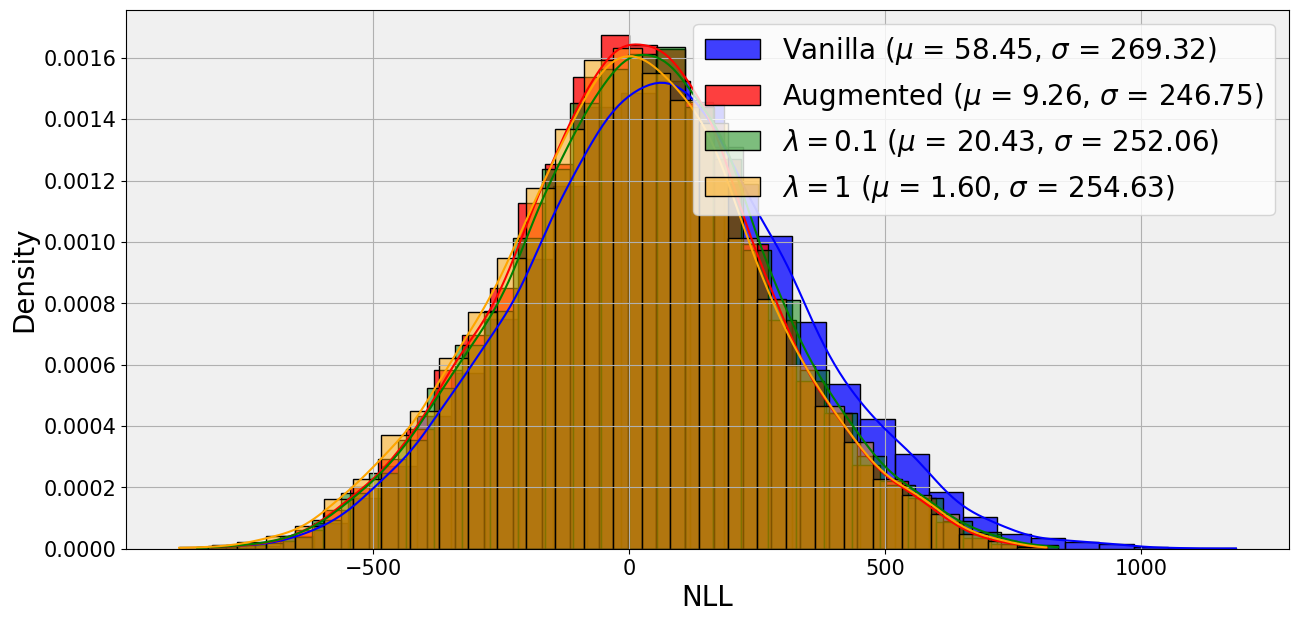

In [26]:
test_diffs_vanilla = np.array(test_lls_vanilla_aug) -  np.array(test_lls_vanilla)
test_diffs_aug =  np.array(test_lls_aug_aug) -  np.array(test_lls_aug)
test_diffs_regularized =  np.array(test_lls_regularized_aug) -  np.array(test_lls_regularized)
test_diffs_regularized_plus =  np.array(test_lls_regularized_plus_aug) -  np.array(test_lls_regularized_plus)

mean_vanilla = np.mean(test_diffs_vanilla)
std_vanilla = np.std(test_diffs_vanilla)

mean_aug = np.mean(test_diffs_aug)
std_aug = np.std(test_diffs_aug)

mean_regularized = np.mean(test_diffs_regularized)
std_regularized = np.std(test_diffs_regularized)

mean_regularized_plus = np.mean(test_diffs_regularized_plus)
std_regularized_plus = np.std(test_diffs_regularized_plus)

fig, axs = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(test_diffs_vanilla, bins=30, stat='density', kde=True, color='blue', alpha=0.75, ax=axs,
             label=f'Vanilla ($\\mu$ = {mean_vanilla:.2f}, $\\sigma$ = {std_vanilla:.2f})')
sns.histplot(test_diffs_aug, bins=30, stat='density', kde=True, color='red', alpha=0.75, ax=axs,
             label=f'Augmented ($\\mu$ = {mean_aug:.2f}, $\\sigma$ = {std_aug:.2f})')
sns.histplot(test_diffs_regularized, bins=30, stat='density', kde=True, color='green', alpha=0.5, ax=axs,
             label=f'$\\lambda = 0.1$ ($\\mu$ = {mean_regularized:.2f}, $\\sigma$ = {std_regularized:.2f})')
sns.histplot(test_diffs_regularized_plus, bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs,
             label=f'$\\lambda = 1$ ($\\mu$ = {mean_regularized_plus:.2f}, $\\sigma$ = {std_regularized_plus:.2f})')

axs.set_xlabel('NLL')
axs.set_ylabel('Density')
axs.set_facecolor('#f0f0f0')
axs.legend()
axs.grid(True)
plt.savefig('images/pc/diff_hist_pc_64.pdf', format='pdf', bbox_inches='tight')
plt.show()

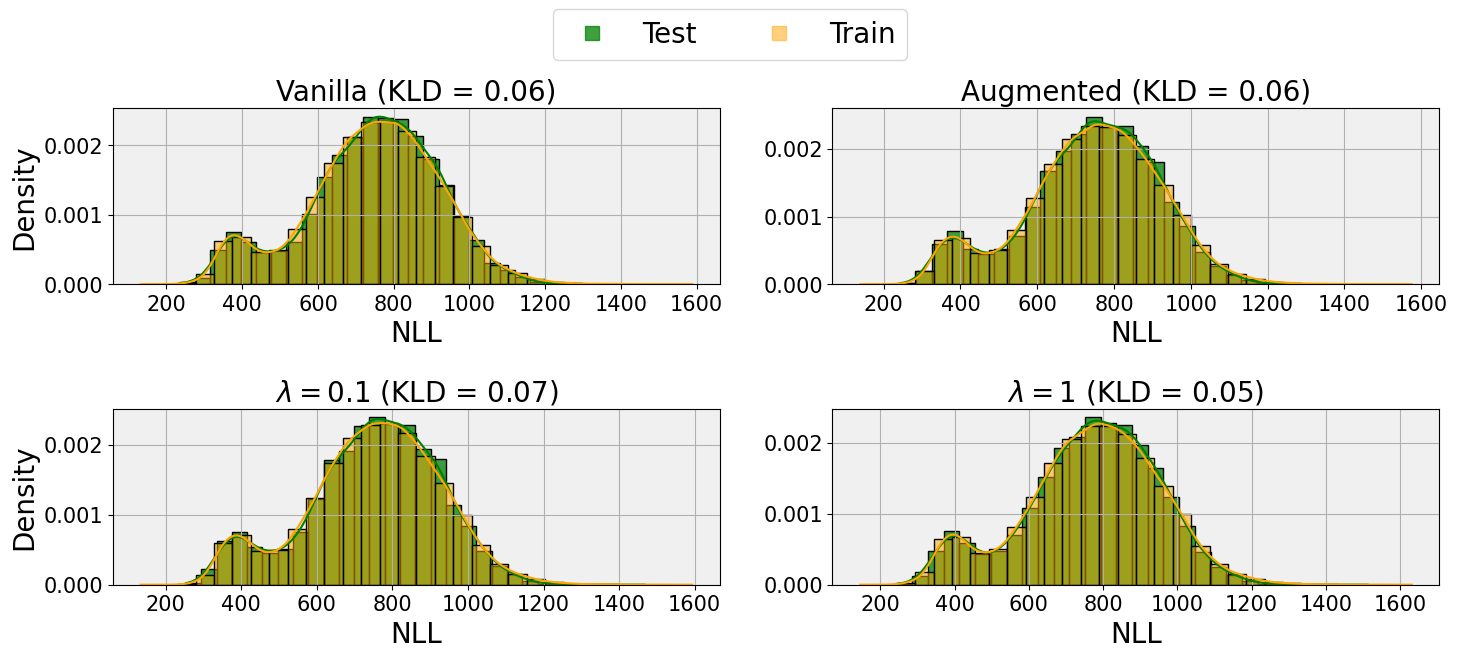

In [29]:
from scipy.stats import entropy

# Function to compute KL divergence
def compute_kl_divergence(train_data, test_data, bins=30):
    train_hist, _ = np.histogram(train_data, bins=bins, density=True)
    test_hist, _ = np.histogram(test_data, bins=bins, density=True)
    # Avoid division by zero by replacing 0 with a small number
    train_hist = np.clip(train_hist, a_min=1e-10, a_max=None)
    test_hist = np.clip(test_hist, a_min=1e-10, a_max=None)
    return entropy(test_hist, train_hist)

# Create the figure with updated size
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

kl_divergence_vanilla = compute_kl_divergence(test_lls_vanilla, train_lls_vanilla)
kl_divergence_aug = compute_kl_divergence(test_lls_aug, train_lls_aug)
kl_divergence_regularized = compute_kl_divergence(test_lls_regularized, train_lls_regularized)
kl_divergence_regularized_plus = compute_kl_divergence(test_lls_regularized_plus, train_lls_regularized_plus)

# Plot for Vanilla
sns.histplot(np.array(test_lls_vanilla), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][0], label='Test')
sns.histplot(np.array(train_lls_vanilla), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][0], label='Train')
axs[0][0].set_title(f'Vanilla (KLD = {kl_divergence_vanilla:.2f})')
axs[0][0].set_xlabel('NLL')
axs[0][0].set_ylabel('Density')
axs[0][0].set_facecolor('#f0f0f0')
axs[0][0].grid(True)

# Plot for Augmented
sns.histplot(np.array(test_lls_aug), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[0][1], label='Test')
sns.histplot(np.array(train_lls_aug), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[0][1], label='Train')
axs[0][1].set_title(f'Augmented (KLD = {kl_divergence_aug:.2f})')
axs[0][1].set_xlabel('NLL')
axs[0][1].set_ylabel('')
axs[0][1].set_facecolor('#f0f0f0')
axs[0][1].grid(True)

# Plot for Regularized (lambda = 0.1)
sns.histplot(np.array(test_lls_regularized), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][0], label='Test')
sns.histplot(np.array(train_lls_regularized), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][0], label='Train')
axs[1][0].set_title(f'$\lambda = 0.1$ (KLD = {kl_divergence_regularized:.2f})')
axs[1][0].set_xlabel('NLL')
axs[1][0].grid(True)
axs[1][0].set_facecolor('#f0f0f0')
axs[1][0].set_ylabel('Density')  # Remove redundant y-axis label

# Plot for Regularized (lambda = 1)
sns.histplot(np.array(test_lls_regularized_plus), bins=30, stat='density', kde=True, color='green', alpha=0.75, ax=axs[1][1], label='Test')
sns.histplot(np.array(train_lls_regularized_plus), bins=30, stat='density', kde=True, color='orange', alpha=0.5, ax=axs[1][1], label='Train')
axs[1][1].set_title(f'$\lambda = 1$ (KLD = {kl_divergence_regularized_plus:.2f})')
axs[1][1].set_xlabel('NLL')
axs[1][1].grid(True)
axs[1][1].set_facecolor('#f0f0f0')
axs[1][1].set_ylabel('')  # Remove redundant y-axis label

# Consolidate the legend
handles = [
    plt.Line2D([0], [0], linestyle='None', marker='s', color='green', markersize=10, alpha=0.75, label='Test'),
    plt.Line2D([0], [0], linestyle='None', marker='s', color='orange', markersize=10, alpha=0.5, label='Train')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.975))
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('images/made/train_test_pc_64.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Samples

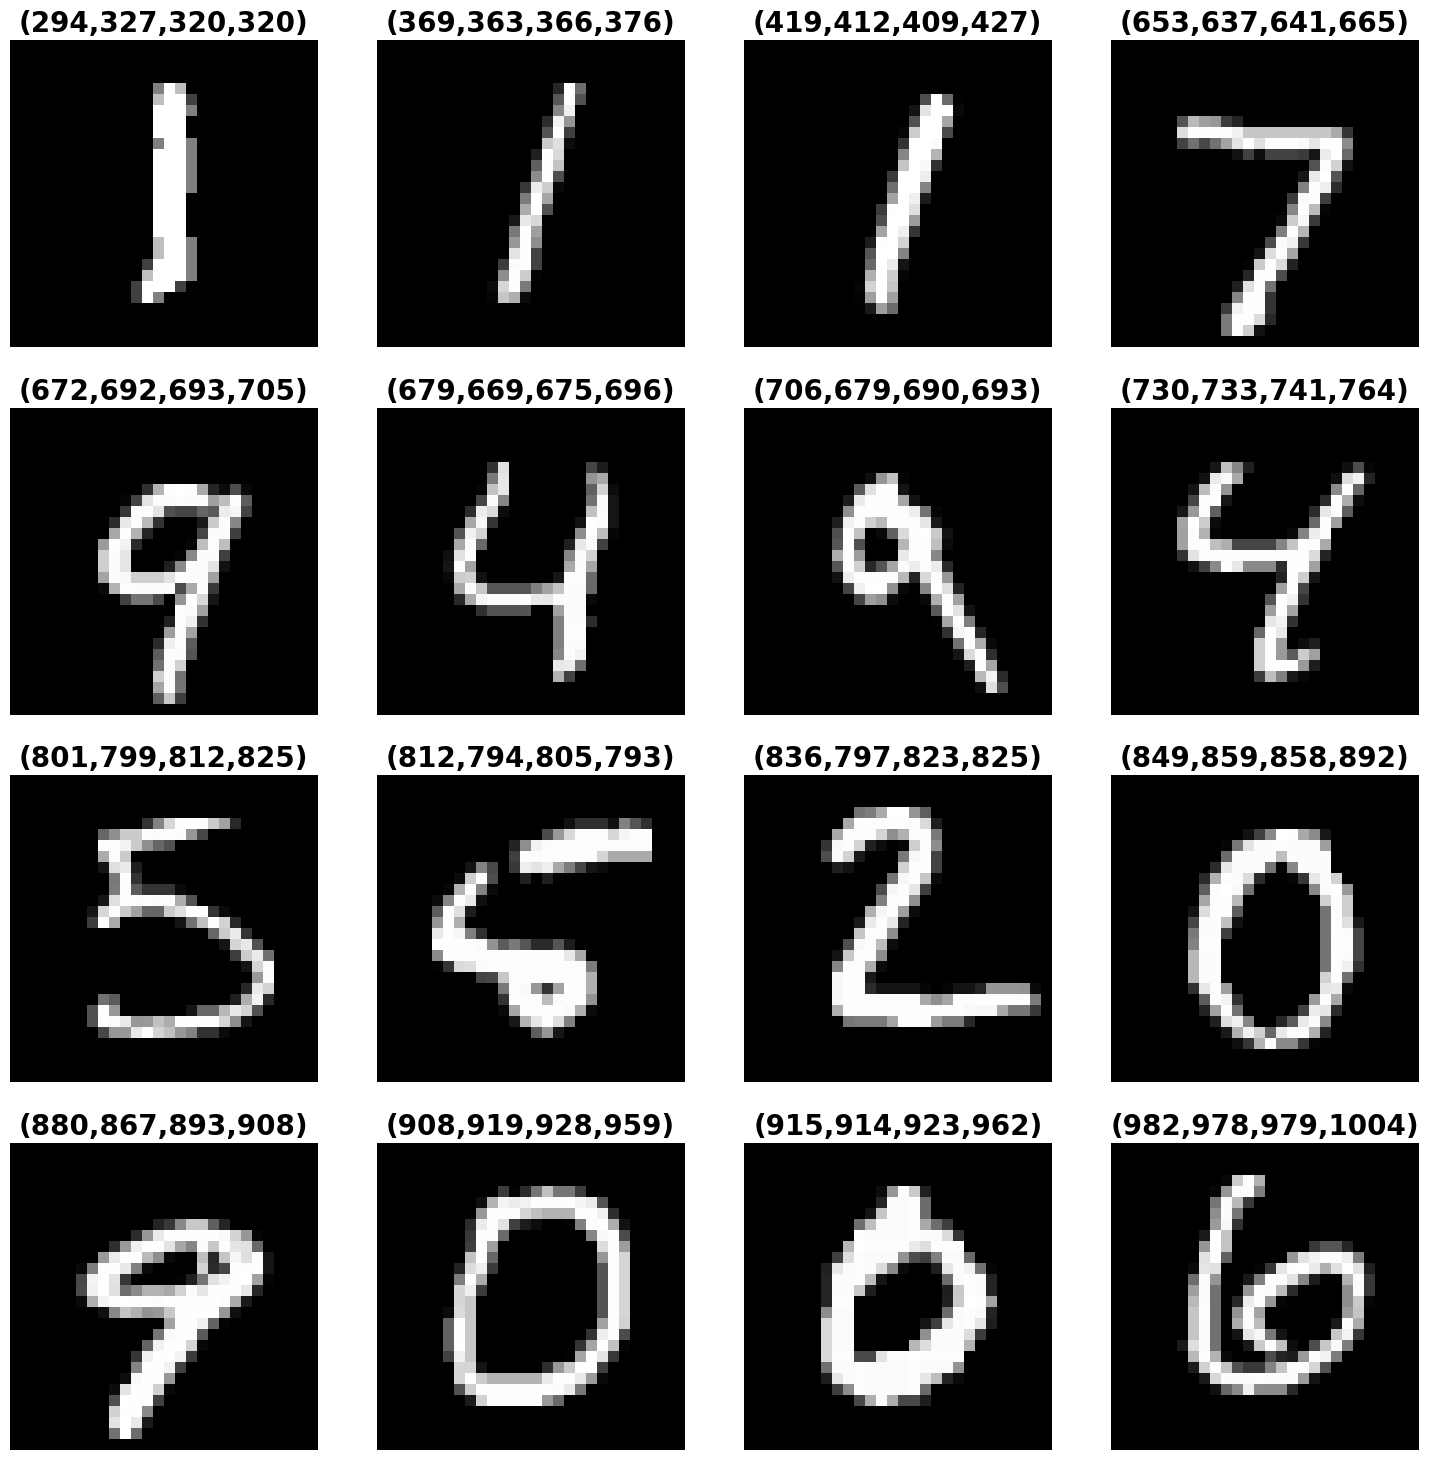

In [9]:
# Collect the images and their NLL values
from util import compute_nlls
from data import load_data
image_nll_pairs = []
_, _, test_data = load_data('mnist', data_dir = './data')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

nll_vanilla = compute_nlls(model_vanilla, data_loader=test_loader, model_type = 'PC').tolist()
nll_reg = compute_nlls(model_reg, data_loader=test_loader, model_type = 'PC').tolist()
nll_aug = compute_nlls(model_aug, data_loader=test_loader, model_type = 'PC').tolist()
nll_reg_plus = compute_nlls(model_reg_plus, data_loader=test_loader, model_type = 'PC').tolist()

for i, (x, _) in enumerate(test_loader):
    image_nll_pairs.append((x.detach().numpy().reshape(28, 28), nll_vanilla[i], nll_aug[i], nll_reg[i], nll_reg_plus[i]))
    if i >= 15:
        break

image_nll_pairs.sort(key=lambda pair: pair[1])
fig1, axes1 = plt.subplots(4, 4, figsize=(15, 15))

for i, (img, nll_vanilla, nll_aug, nll_reg, nll_reg_plus) in enumerate(image_nll_pairs):
    ax = axes1[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"({round(nll_vanilla)},{round(nll_aug)},{round(nll_reg)},{round(nll_reg_plus)})", fontsize=20, fontweight='bold')
    ax.axis('off')

fig1.tight_layout()
plt.savefig('images/pc/samples_pc_test.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
plot_samples(model_vanilla, 49, model_type = 'PC', save_dir = 'images/pc/samples_pc_vanilla_64.pdf')
plot_samples(model_aug, 49, model_type = 'PC', save_dir = 'images/pc/samples_pc_aug_64.pdf')
plot_samples(model_reg, 49, model_type = 'PC', save_dir = 'images/pc/samples_pc_reg_64.pdf')
plot_samples(model_reg_plus, 49, model_type = 'PC', save_dir = 'images/pc/samples_pc_reg_plus_64.pdf')

# KID

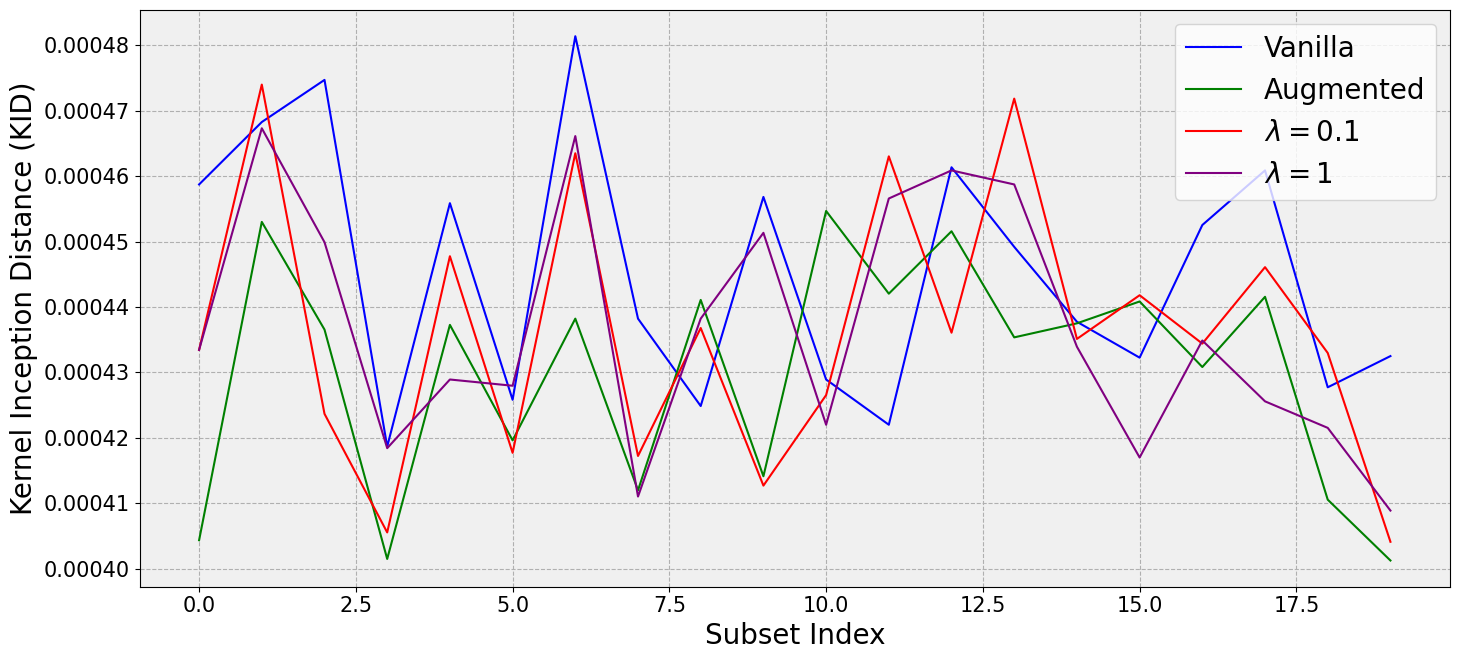

In [39]:
from matplotlib.ticker import FuncFormatter

kids_vanilla, kid_stats_vanilla = eval_dic_vanilla['KID']['kids'], eval_dic_vanilla['KID']['std']
kids_aug, kid_stats_aug = eval_dic_aug['KID']['kids'], eval_dic_aug['KID']['std']
kids_reg, kid_stats_reg = eval_dic_reg['KID']['kids'], eval_dic_reg['KID']['std']
kids_reg_plus, kid_stats_reg_plus = eval_dic_reg_plus['KID']['kids'], eval_dic_reg_plus['KID']['std']

fig, ax = plt.subplots(figsize=(15, 7))
ax.set_facecolor('#f0f0f0')
ax.plot(range(len(kids_vanilla)), kids_vanilla, linestyle='-', color='blue', label=f'Vanilla')
ax.plot(range(len(kids_aug)), kids_aug, linestyle='-', color='green', label=f'Augmented')
ax.plot(range(len(kids_reg)), kids_reg, linestyle='-', color='red', label=f'$\lambda = 0.1$')
ax.plot(range(len(kids_reg_plus)), kids_reg_plus, linestyle='-', color='purple', label=f'$\lambda = 1$')

#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1e}'))
#ax.set_ylim([4e-4, 4.8e-4])
ax.set_xlabel('Subset Index')
ax.set_ylabel('Kernel Inception Distance (KID)')
ax.grid(True, which="both", ls="--")
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('images/PC/kids_pc_mnist.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [15]:
print(f'Vanilla (mean={kid_stats_vanilla[0]}, std={kid_stats_vanilla[1]})')
print(f'Augmented (mean={kid_stats_aug[0]}, std={kid_stats_aug[1]})')
print(f'$\lambda=0.1$ (mean={kid_stats_reg[0]}, std={kid_stats_reg[1]})')
print(f'$\lambda=1$ (mean={kid_stats_reg_plus[0]}, std={kid_stats_reg_plus[1]})')

Vanilla (mean=0.0004454135778360069, std=1.8372251361142844e-05)
Augmented (mean=0.0004301905573811382, std=1.6920710550039075e-05)
$\lambda=0.1$ (mean=0.00043621062650345266, std=1.9896941012120806e-05)
$\lambda=1$ (mean=0.0004366278590168804, std=1.8080756490235217e-05)


# Precision-Recall

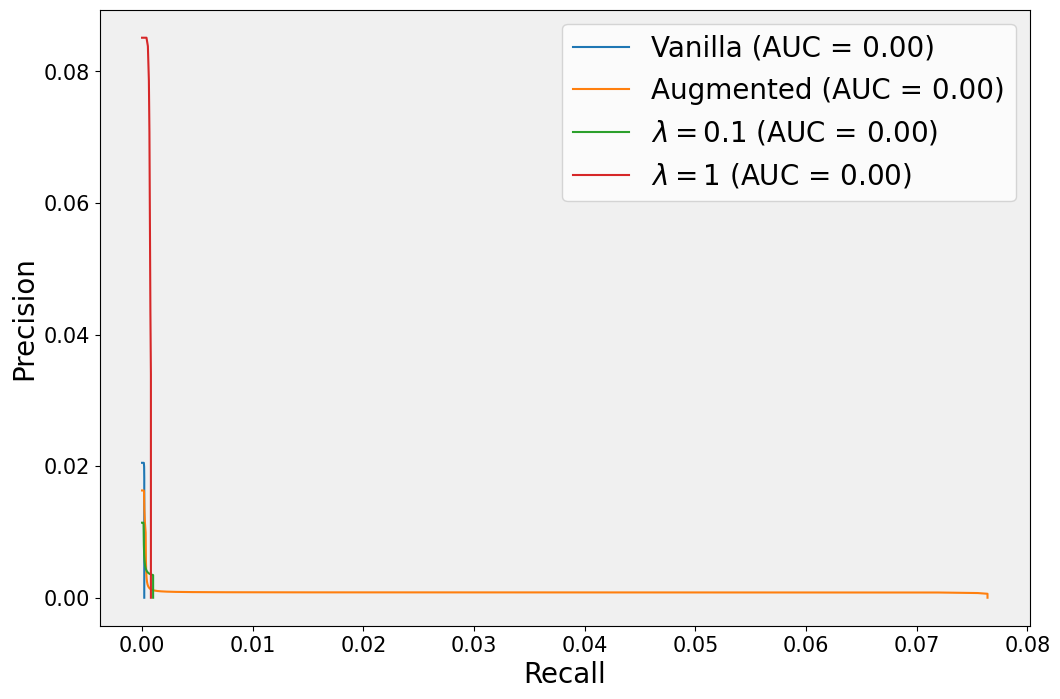

In [16]:
prd_vanilla = eval_dic_vanilla['PRD']
precisions_vanilla, recalls_vanilla = prd_vanilla['precisions'], prd_vanilla['recalls']
prd_aug = eval_dic_aug['PRD']
precisions_aug, recalls_aug = prd_aug['precisions'], prd_aug['recalls']
prd_reg = eval_dic_reg['PRD']
precisions_reg, recalls_reg = prd_reg['precisions'], prd_reg['recalls']
prd_reg_plus = eval_dic_reg_plus['PRD']
precisions_reg_plus, recalls_reg_plus = prd_reg_plus['precisions'], prd_reg_plus['recalls']
auc_vanilla = np.trapz(recalls_vanilla, precisions_vanilla)
auc_aug = np.trapz(recalls_aug, precisions_aug)
auc_reg = np.trapz(recalls_reg, precisions_reg)
auc_reg_plus = np.trapz(recalls_reg_plus, precisions_reg_plus)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(precisions_vanilla, recalls_vanilla, label=f'Vanilla (AUC = {auc_vanilla:.2f})')
ax.plot(precisions_aug, recalls_aug, label=f'Augmented (AUC = {auc_aug:.2f})')
ax.plot(precisions_reg, recalls_reg, label=f'$\lambda = 0.1$ (AUC = {auc_reg:.2f})')
ax.plot(precisions_reg_plus, recalls_reg_plus, label=f'$\lambda = 1$ (AUC = {auc_reg_plus:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_facecolor('#f0f0f0')
ax.legend(loc='best')
plt.savefig('images/PC/pr_curve_mnist_pc.pdf', format='pdf', bbox_inches='tight')
plt.show()

# OOD detection

In [11]:
#roc_pc_vanilla = eval_dic_vanilla['roc_pc']
#fpr_vanilla, tpr_vanilla, roc_auc_vanilla, recall_vanilla, precision_vanilla, pr_auc_vanilla \
    #= roc_pc_vanilla['fpr'], roc_pc_vanilla['tpr'], roc_pc_vanilla['roc_auc'], roc_pc_vanilla['recall'], \
    #roc_pc_vanilla['precision'], roc_pc_vanilla['pr_auc']
#roc_pc_aug = eval_dic_aug['roc_pc']
#fpr_aug, tpr_aug, roc_auc_aug, recall_aug, precision_aug, pr_auc_aug \
    #= roc_pc_aug['fpr'], roc_pc_aug['tpr'], roc_pc_aug['roc_auc'], roc_pc_aug['recall'], \
    #roc_pc_aug['precision'], roc_pc_aug['pr_auc']
#roc_pc_reg = eval_dic_reg['roc_pc']
#fpr_reg, tpr_reg, roc_auc_reg, recall_reg, precision_reg, pr_auc_reg = roc_pc_reg['fpr'], roc_pc_reg['tpr'], \
 #   roc_pc_reg['roc_auc'], roc_pc_reg['recall'], roc_pc_reg['precision'], roc_pc_reg['pr_auc']
#roc_pc_reg_plus = eval_dic_reg_plus['roc_pc']
#fpr_reg_plus, tpr_reg_plus, roc_auc_reg_plus, recall_reg_plus, precision_reg_plus, pr_auc_reg_plus = roc_pc_reg_plus['fpr'], \
   # roc_pc_reg_plus['tpr'], roc_pc_reg_plus['roc_auc'], roc_pc_reg_plus['recall'], roc_pc_reg_plus['precision'], roc_pc_reg_plus['pr_auc']
from util import roc_pc
from data import load_data
train_data, _, test_data = load_data('mnist', data_dir = './data', binarize = False, val = False)
test_loader = DataLoader(test_data, batch_size=1, shuffle = True)
_, _, test_data_fashion = load_data('fashion', data_dir = './data', binarize = False, val = False)
test_loader_fashion = DataLoader(test_data_fashion, batch_size=1, shuffle = False)

ood_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']
test_lls_mnist_vanilla, test_lls_fashion_vanilla = ood_lls_vanilla['mnist'], ood_lls_vanilla['fashion']
ood_lls_aug = eval_dic_aug['OOD_NLLs_test']
test_lls_mnist_aug, test_lls_fashion_aug = ood_lls_aug['mnist'], ood_lls_aug['fashion']
ood_lls_reg = eval_dic_reg['OOD_NLLs_test']
test_lls_mnist_reg, test_lls_fashion_reg = ood_lls_reg['mnist'], ood_lls_reg['fashion']
ood_lls_reg_plus = eval_dic_reg_plus['OOD_NLLs_test']
test_lls_mnist_reg_plus, test_lls_fashion_reg_plus = ood_lls_reg_plus['mnist'], ood_lls_reg_plus['fashion']

fpr_vanilla, tpr_vanilla, thresholds_vanilla, roc_auc_vanilla, precision_vanilla, recall_vanilla, pr_thresholds_vanilla, pr_auc_vanilla, _, nll_emnist_vanilla \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_fashion, \
model = model_vanilla, model_type = 'PC', nll_mnist = np.array(test_lls_mnist_vanilla), nll_ood = np.array(test_lls_fashion_vanilla))

fpr_aug, tpr_aug, thresholds_aug, roc_auc_aug, precision_aug, recall_aug, pr_thresholds_aug, pr_auc_aug, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_fashion, \
model = model_aug, model_type = 'PC', nll_mnist = np.array(test_lls_mnist_aug), nll_ood = np.array(test_lls_fashion_aug))

fpr_reg, tpr_reg, thresholds_reg, roc_auc_reg, precision_reg, recall_reg, pr_thresholds_reg, pr_auc_reg, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_fashion, \
model = model_reg, model_type = 'PC', nll_mnist = np.array(test_lls_mnist_reg), nll_ood = np.array(test_lls_fashion_reg))

fpr_reg_plus, tpr_reg_plus, thresholds_reg_plus, roc_auc_reg_plus, precision_reg_plus, recall_reg_plus, pr_thresholds_reg_plus, pr_auc_reg_plus, _, _ \
= roc_pc(test_loader = test_loader, test_loader_ood = test_loader_fashion, \
model = model_reg_plus, model_type = 'PC', nll_mnist = np.array(test_lls_mnist_reg_plus), nll_ood = np.array(test_lls_fashion_reg_plus))

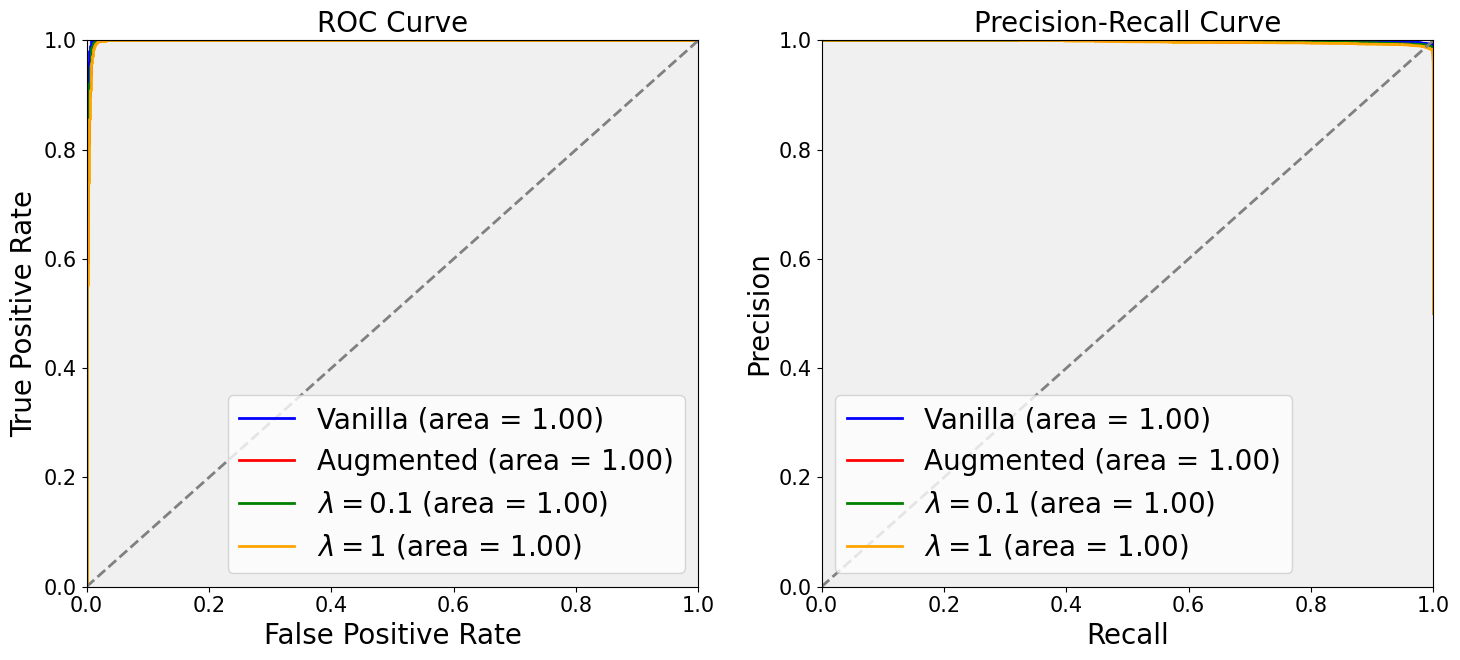

In [13]:
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(15, 7))
ax_roc.set_facecolor('#f0f0f0')
ax_pr.set_facecolor('#f0f0f0')
ax_roc.plot(fpr_vanilla, tpr_vanilla, color='blue', lw=2, label=f'Vanilla (area = {roc_auc_vanilla:.2f})')
ax_roc.plot(fpr_aug, tpr_aug, color='red', lw=2, label=f'Augmented (area = {roc_auc_aug:.2f})')
ax_roc.plot(fpr_reg, tpr_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {roc_auc_reg:.2f})')
ax_roc.plot(fpr_reg_plus, tpr_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {roc_auc_reg_plus:.2f})')
ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.0])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve')
ax_roc.legend(loc="lower right")

ax_pr.plot(recall_vanilla, precision_vanilla, color='blue', lw=2, label=f'Vanilla (area = {pr_auc_vanilla:.2f})')
ax_pr.plot(recall_aug, precision_aug, color='red', lw=2, label=f'Augmented (area = {pr_auc_aug:.2f})')
ax_pr.plot(recall_reg, precision_reg, color='green', lw=2, label=f'$\lambda = 0.1$ (area = {pr_auc_reg:.2f})')
ax_pr.plot(recall_reg_plus, precision_reg_plus, color='orange', lw=2, label=f'$\lambda = 1$ (area = {pr_auc_reg_plus:.2f})')
ax_pr.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.0])
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision-Recall Curve')
ax_pr.legend(loc="lower left")
plt.tight_layout()
plt.savefig('images/PC/rocpr_mnist_fashion_pc.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Typicality Test

0.13820826130662894
0.13820826130662894
0.13820826130662894
0.12685781387252384
0.1457894160311431
0.11662120016445007


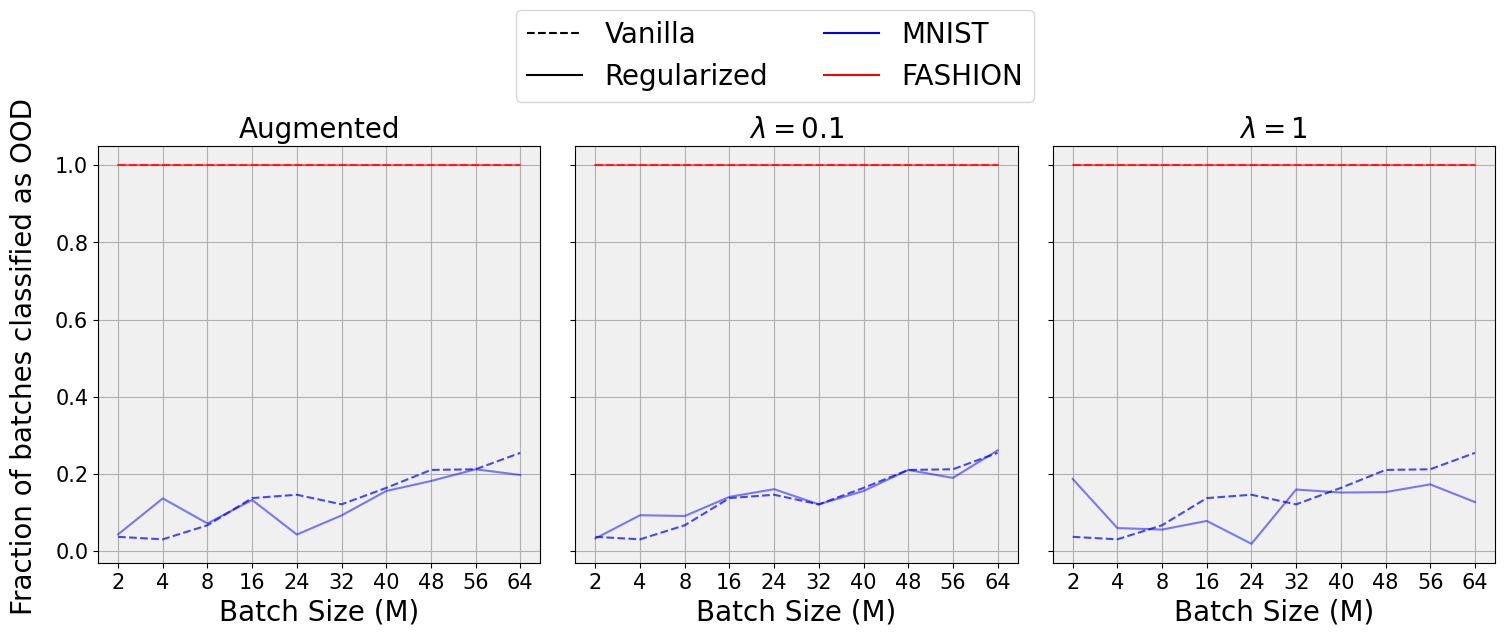

In [29]:
import matplotlib.pyplot as plt

# Example data setup
data_vanilla = eval_dic_vanilla['typicality']
data_aug = eval_dic_aug['typicality']
data_reg = eval_dic_reg['typicality']
data_reg_plus = eval_dic_reg_plus['typicality']

datasets = {
    'Augmented': data_aug,
    '$\lambda=0.1$': data_reg,
    '$\lambda=1$': data_reg_plus
}

fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Plotting the Vanilla model as a common dashed line in each subplot
for ax in axs:
    M_values_vanilla = list(data_vanilla.keys())
    mnist_values_vanilla = [data_vanilla[m]['mnist'] for m in M_values_vanilla]
    fashion_values_vanilla = [data_vanilla[m]['fashion'] for m in M_values_vanilla]
    M_values_vanilla = [m.split('=')[1] for m in M_values_vanilla]
    ax.plot(M_values_vanilla, mnist_values_vanilla, linestyle='--', color='blue', alpha=0.7)
    ax.plot(M_values_vanilla, fashion_values_vanilla, linestyle='--', color='red', alpha=0.7)

# Plotting the other models
for i, (ax, (label, data)) in enumerate(zip(axs, datasets.items())):
    M_values = list(data.keys())
    mnist_values = [data[m]['mnist'] for m in M_values]
    emnist_values = [data[m]['fashion'] for m in M_values]
    M_values = [m.split('=')[1] for m in M_values]
    
    ax.plot(M_values, mnist_values, linestyle='-', color='blue', alpha=0.5)
    ax.plot(M_values, emnist_values, linestyle='-', color='red', alpha=0.5)
    ax.set_xlabel('Batch Size (M)')
    ax.set_title(f'{label}')
    ax.grid(True)
    ax.set_facecolor('#f0f0f0')

# Custom legend
handles = [
    plt.Line2D([0], [0], linestyle='--', color='black', label='Vanilla'),
    plt.Line2D([0], [0], linestyle='-', color='black', label='Regularized'),
    plt.Line2D([0], [0], linestyle='-', color='blue', label='MNIST'),
    plt.Line2D([0], [0], linestyle='-', color='red', label='FASHION')
]

fig.text(-0.01, 0.5, 'Fraction of batches classified as OOD', va='center', rotation='vertical')
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make space for the legend
plt.savefig('images/PC/ood_mnist_fashion_typicality_95.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Visualization

In [19]:
ood_lls_vanilla = eval_dic_vanilla['OOD_NLLs_test']
test_lls_mnist_vanilla, test_lls_fashion_vanilla = ood_lls_vanilla['mnist'], ood_lls_vanilla['fashion']
ood_lls_aug = eval_dic_aug['OOD_NLLs_test']
test_lls_mnist_aug, test_lls_fashion_aug = ood_lls_aug['mnist'], ood_lls_aug['fashion']
ood_lls_reg = eval_dic_reg['OOD_NLLs_test']
test_lls_mnist_reg, test_lls_fashion_reg = ood_lls_reg['mnist'], ood_lls_reg['fashion']
ood_lls_reg_plus = eval_dic_reg_plus['OOD_NLLs_test']
test_lls_mnist_reg_plus, test_lls_fashion_reg_plus = ood_lls_reg_plus['mnist'], ood_lls_reg_plus['fashion']

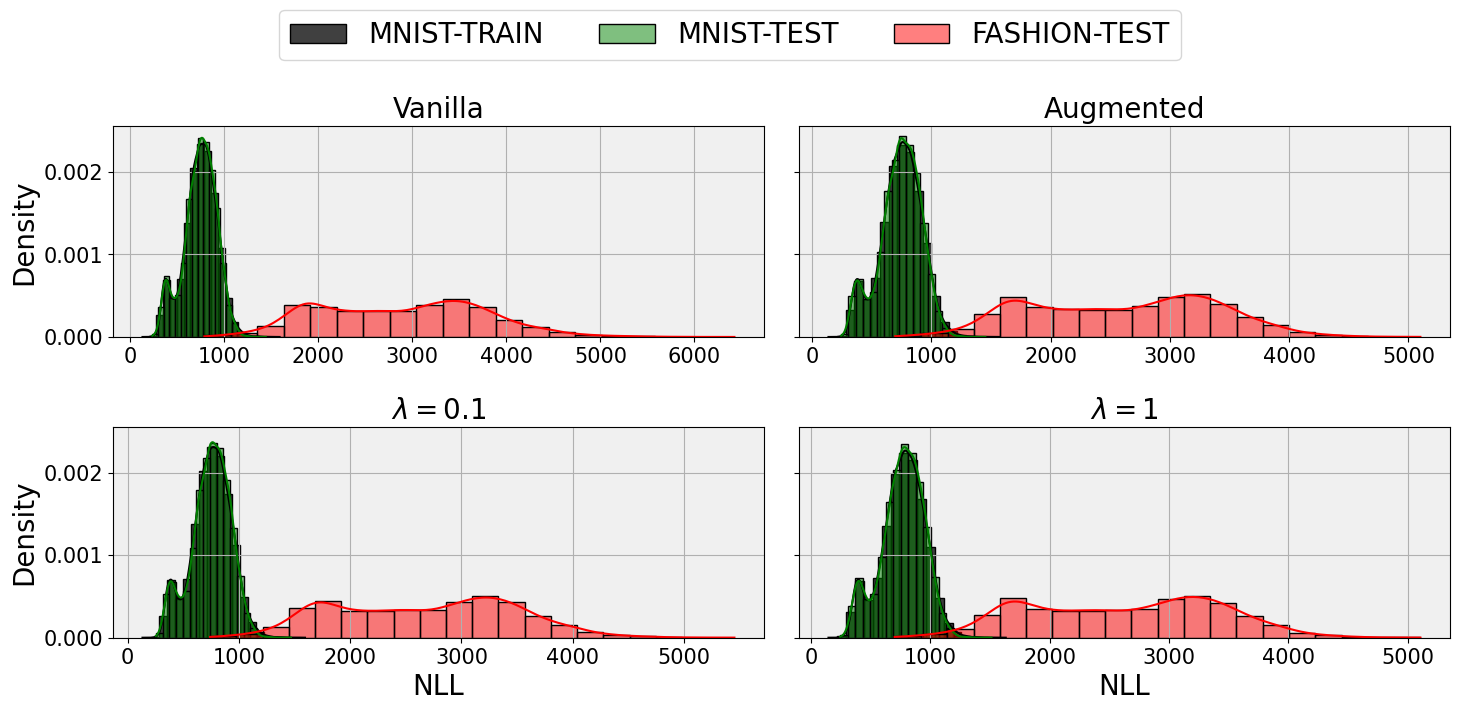

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True)
# Vanilla
sns.histplot(train_lls_vanilla, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[0][0], label='MNIST-TRAIN')
sns.histplot(test_lls_mnist_vanilla, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[0][0], label='MNIST-TEST')
sns.histplot(test_lls_fashion_vanilla, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[0][0], label='FASHION-TEST')
axs[0][0].set_title('Vanilla')
axs[0][0].set_ylabel('Density')
axs[0][0].grid(True)
axs[0][0].set_facecolor('#f0f0f0')
# Augmented
sns.histplot(train_lls_aug, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[0][1])
sns.histplot(test_lls_mnist_aug, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[0][1])
sns.histplot(test_lls_fashion_aug, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[0][1])
axs[0][1].set_title('Augmented')
axs[0][1].grid(True)
axs[0][1].set_ylabel('')
axs[0][1].set_facecolor('#f0f0f0')
# Regularized (lambda = 0.1)
sns.histplot(train_lls_regularized, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[1][0])
sns.histplot(test_lls_mnist_reg, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[1][0])
sns.histplot(test_lls_fashion_reg, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[1][0])
axs[1][0].set_title('$\lambda = 0.1$')
axs[1][0].set_xlabel('NLL')
axs[1][0].set_ylabel('Density')
axs[1][0].grid(True)
axs[1][0].set_facecolor('#f0f0f0')
# Regularized Plus (lambda = 1)
sns.histplot(train_lls_regularized_plus, bins=20, stat='density', kde=True, color='black', alpha=0.75, ax=axs[1][1])
sns.histplot(test_lls_mnist_reg_plus, bins=20, stat='density', kde=True, color='green', alpha=0.5, ax=axs[1][1])
sns.histplot(test_lls_fashion_reg_plus, bins=20, stat='density', kde=True, color='red', alpha=0.5, ax=axs[1][1])
axs[1][1].set_title('$\lambda = 1$')
axs[1][1].set_xlabel('NLL')
axs[1][1].grid(True)
axs[1][1].set_ylabel('')
axs[1][1].set_facecolor('#f0f0f0')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/pc/ood_histograms_mnist_fashion_pc.pdf', format='pdf', bbox_inches='tight')
plt.show()